In [1]:
#This analysis requires two files per subject:
#02_awake_drowsy_merged_800ms_posttrl_epochs --> eeglab set file per subject (here '02')
#02_trialstruc.mat --> trial file containing details of stimulus, responses per subject (here '02')
#To get the above files per subject, run the script process_posttrial_createERPs_MVPA

In [2]:
# Load all modules..
import pickle
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import stats
from copy import deepcopy
import seaborn as sns
import os.path
import matplotlib
import matplotlib.pylab as pylab
import pandas as pd

In [3]:
# Load all mne modules..
import mne
from mne import io, read_epochs, Epochs, read_evokeds, combine_evoked
from mne.preprocessing import ICA
from mne.decoding import (Vectorizer, SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)
from mne.stats import ttest_1samp_no_p
from mne.stats import (spatio_temporal_cluster_1samp_test,
                       permutation_cluster_1samp_test)

In [4]:
# Load all scikit modules..
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC,LinearSVR
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import StratifiedKFold

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
# check versions of modules used..
print ('mne version: '+ mne.__version__)
print ('scikit version: '+ sklearn.__version__)
print ('matplotlib version: '+ matplotlib.__version__)
print ('seaborn version: '+ sns.__version__)

mne version: 0.19.2
scikit version: 0.22
matplotlib version: 3.3.4
seaborn version: 0.9.0


In [7]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [8]:
label_fontsize = 16
title_fontsize = 16

In [9]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [10]:
sns.set(font_scale=1.25, style="whitegrid")

In [11]:
#parameters for running the analysis again..
rerun = True

In [12]:
def movingaverage(y, window_length):
    y_smooth = scipy.convolve(y,np.ones(window_length,dtype='float'), 'same')/scipy.convolve(np.ones(len(y)),
                                                                              np.ones(window_length), 'same')
    return y_smooth

In [13]:
def decodingplot(scores_cond, p_values_cond, times, rts = None, alpha=0.05, color = 'r', tmin= -0.3, tmax = 1.6):
    scores = np.array(scores_cond)
    sig= p_values_cond < alpha
    
    scores_m = np.nanmean(scores, axis=0)
    n = len(scores)
    n -= sum(np.isnan(np.mean(scores, axis=1))) #identify the nan subjs and remove them..
    sem = np.nanstd(scores, axis=0) / np.sqrt(n)
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[20, 6], sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1.25],'hspace': 0.6})
    #fig, ax1 = plt.subplots(nrows=1, figsize=[20, 4])

    ax1.plot(times, scores_m, 'k',linewidth=1,)
    ax1.fill_between(times, scores_m-sem, scores_m+sem, color=color, alpha=0.3)
    
    split_ydata = scores_m
    split_ydata[~sig] = np.nan
     
    #shade the significant regions..
    ax1.plot(times, split_ydata,color='k', linewidth=3)
    ax1.fill_between(times, y1=split_ydata, y2=0.5, alpha=0.7, facecolor=color)
    
    
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    ax1.grid(True)
    
           
    ax1.axhline(y=0.5, linewidth=0.75, color='k',linestyle = '--')
    ax1.axvline(x=0, linewidth=0.75, color='k',linestyle = '--')
    
    timeintervals = np.arange(tmin, tmax, 0.1)
    timeintervals = timeintervals.round(decimals=2)
    
    ax1.set_xticks(timeintervals) 
    #ax1.axes.xaxis.set_ticklabels([])
    
    for patch in ax1.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    
    ax1.patch.set_edgecolor('black')  

    ax1.patch.set_linewidth('0') 
    
    if rts is not None:
         
       medianprops = dict(linestyle='--', linewidth=1, color='black')
       meanlineprops = dict(linestyle='--', linewidth=0, color='black')
       whiskerlineprops = dict(linestyle='-', linewidth=1, color='black')

       ax2 = sns.boxplot(x=rts,whis=np.inf, ax=ax2,color = color,showbox=True,dodge=False, width = 0.25,
                         meanprops=meanlineprops, meanline=True,showmeans=False, showfliers=True,
                         showcaps=True,medianprops=medianprops, whiskerprops = whiskerlineprops,
                         capprops = whiskerlineprops)
    
       for patch in ax2.artists:
           r, g, b, a = patch.get_facecolor()
           patch.set_facecolor((r, g, b, .6))
            
        
        
       ax2.artists[0].set_edgecolor('black')
       ax2.artists[0].set_linewidth(1)
    
       sns.stripplot(x=rts, jitter=True, linewidth=1, size = 8, ax=ax2,color=color,edgecolor ="black")
    
       ax2.set(xlim=(np.min(timeintervals), np.max(timeintervals)))
       ax2.set_xticks(timeintervals)  

       plt.box(False)
       ax2.grid(True)
    
    else:
        
       ax2.set_xticks(timeintervals)  
       plt.box(False)
       ax2.grid(False)
       ax2.spines['top'].set_visible(False)
       ax2.spines['right'].set_visible(False)
       ax2.spines['bottom'].set_visible(False)
       ax2.spines['left'].set_visible(False)
        
       plt.xticks([])
       plt.yticks([])
        

    for a in fig.axes:
        a.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
    
    class Scratch(object):
        pass

    returnval1 = Scratch()
    returnval2 = Scratch()
    
    returnval1.axes = ax1
    returnval1.times = times[sig]
    returnval1.scores = scores_m[sig]
    
    returnval2.axes = ax2
    
    return returnval1, returnval2

In [14]:
chance = .5
alpha = 0.05

#adapted from https://github.com/kingjr/decod_unseen_maintenance/blob/master/scripts/base.py
#performs stats of the group level..
#X is usually nsubj x ntpts -> composed of mean roc scores per subj per timepoint..
#performs cluster stats on X to identify regions of tpts that have roc significantly 
#differ from chance..

def _stats(X, connectivity=None, n_jobs=-1):
    """Cluster statistics to control for multiple comparisons.
    Parameters
    ----------
    X : array, shape (n_samples, n_space, n_times)
        The data, chance is assumed to be 0.
    connectivity : None | array, shape (n_space, n_times)
        The connectivity matrix to apply cluster correction. If None uses
        neighboring cells of X.
    n_jobs : int
        The number of parallel processors.
    """
    n_subjects = len(X)
    X = np.array(X)
    X = X[:, :, None] if X.ndim == 2 else X
    #this functions gets the t-values and performs a cluster permutation test on them to determine
    #p-values..
    p_threshold = 0.05
    t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects - 1)
    print('number of subjects:', n_subjects)
    print('t-threshold is:', t_threshold)
    print('p-threshold is:', p_threshold)
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
        X, out_type='mask', stat_fun=_stat_fun, n_permutations=2**12, seed = 1234,
        n_jobs=n_jobs, connectivity=connectivity,threshold=t_threshold)
    p_values_ = np.ones_like(X[0]).T
    #rearrange the p-value per cluster..
    for cluster, pval in zip(clusters, p_values):
        p_values_[cluster.T] = pval
    return np.squeeze(p_values_).T

def _stat_fun(x, sigma=0, method='relative'):
    """This secondary function reduces the time of computation of p-values and adjusts for small-variance
       values
    """
    t_values = ttest_1samp_no_p(x, sigma=sigma, method=method)
    t_values[np.isnan(t_values)] = 0
    return t_values

In [15]:
basefolderpath = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
output_dir = 'decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [16]:
inputfolder = basefolderpath + "decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/"
outputfolder = basefolderpath + "decAlertnessDecisionmaking_JNeuroscience2021/Results/results_decodingstim/"

In [17]:
fig_dir = basefolderpath + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

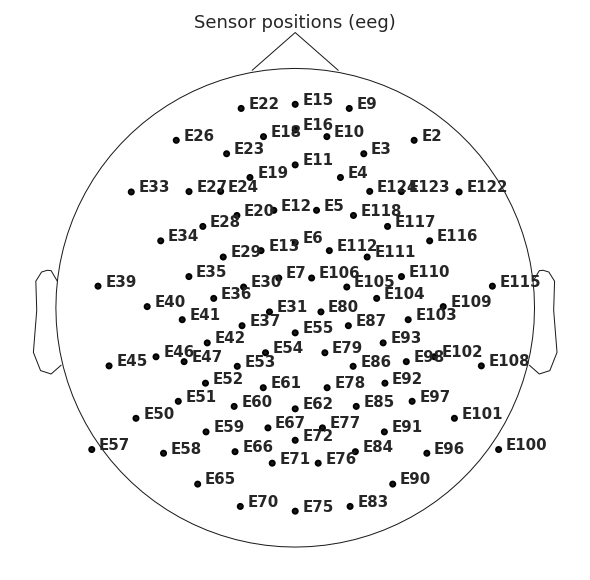

In [18]:
elec_fileloc = basefolderpath + 'decAlertnessDecisionmaking_JNeuroscience2021/Misc/'
elec_filename = 'GSN-HydroCel-92.sfp'
fname = elec_fileloc + elec_filename
montage = mne.channels.read_custom_montage(fname)
plot = montage.plot(kind = 'topomap', show_names=True)

In [19]:
def _run(subj_id, cond_str):
        # Runs temporal generalization for a given subject
    
    subject_setfile = inputfolder + "s_" + subj_id + "_awake_drowsy_merged_800ms_posttrl_epochs.set"
    
    
    epochs = io.read_epochs_eeglab(subject_setfile, events=None, event_id=None, eog=(),\
                                verbose=None, uint16_codec=None)
    
    epochs.set_montage(montage)
    
    epochs = epochs.resample(100, npad='auto')
    
    subject_matfile = inputfolder + "s_" + subj_id +"_trialstruc.mat"
        
    mat = loadmat(subject_matfile,squeeze_me=True)
    
    # Rearrange Stimstruct and select indices for dropping zero angle trials..
    stimstruct = deepcopy(mat['Stimstruct'])
    stimstruct = np.array([s.encode() for s in stimstruct])
    stimstruct = stimstruct.astype('U13') #converting to unicode..
    
    stimangle = deepcopy(mat['Stimangle'])
    
    stimrt = deepcopy(mat['Ovrtvalue'])
    
    
    event_zeAC = np.array(stimstruct == 'zeAC')
    event_zeAI = np.array(stimstruct == 'zeAI')
    event_zeAN = np.array(stimstruct == 'zeAN')
    
    event_zeDC = np.array(stimstruct == 'zeDC')
    event_zeDI = np.array(stimstruct == 'zeDI')
    event_zeDN = np.array(stimstruct == 'zeDN')
    
    event_zeRC = np.array(stimstruct == 'zeRC')
    event_zeRI = np.array(stimstruct == 'zeRI')
    event_zeRN = np.array(stimstruct == 'zeRN')
    
    #stimrt_fasttrls = stimrt < 0.3  #for removing faster trial responses primarily in alert condition..
    
    
    event_sel = ~np.array(event_zeAC | event_zeAI | event_zeAN | \
                          event_zeDC | event_zeDI | event_zeDN | \
                          event_zeRC | event_zeRI | event_zeRN ) #stimrt_fasttrls
    
    # Remove the zero stim trials in all conditions..
    epoch_clean = epochs[event_sel]
    stimstruct_clean = stimstruct[event_sel]
    stimangle_clean = stimangle[event_sel]
    stimrt_clean = stimrt[event_sel]
    
    
    # Plot the average response across trials
    evoked = epoch_clean.average()

    
    #Get indices of all stimulus events now..
    stim_leAC = (stimstruct_clean == 'leAC')
    stim_ldAC = (stimstruct_clean == 'ldAC')
    stim_rdAC = (stimstruct_clean == 'rdAC')
    stim_reAC = (stimstruct_clean == 'reAC')
    stim_leDC = (stimstruct_clean == 'leDC')
    stim_ldDC = (stimstruct_clean == 'ldDC')
    stim_rdDC = (stimstruct_clean == 'rdDC')
    stim_reDC = (stimstruct_clean == 'reDC')
    
    
    stim_leAI = (stimstruct_clean == 'leAI')
    stim_ldAI = (stimstruct_clean == 'ldAI')
    stim_rdAI = (stimstruct_clean == 'rdAI')
    stim_reAI = (stimstruct_clean == 'reAI')
    stim_leDI = (stimstruct_clean == 'leDI')
    stim_ldDI = (stimstruct_clean == 'ldDI')
    stim_rdDI = (stimstruct_clean == 'rdDI')
    stim_reDI = (stimstruct_clean == 'reDI')
    
    #Make meaning full indices from the above indices..
    stim_alertCorrect  = (stim_leAC | stim_ldAC | stim_rdAC | stim_reAC)
    stim_drowsyCorrect = (stim_leDC | stim_ldDC | stim_rdDC | stim_reDC)
    
    stim_leftCorrect  = (stim_leAC | stim_ldAC | stim_leDC | stim_ldDC)
    stim_rightCorrect = (stim_reAC | stim_rdAC | stim_reDC | stim_rdDC)
    
    stim_leftAlertCorrect      = (stim_leAC | stim_ldAC)
    stim_rightAlertCorrect     = (stim_reAC | stim_rdAC)
    stim_leftDrowsyCorrect     = (stim_leDC | stim_ldDC)
    stim_rightDrowsyCorrect    = (stim_reDC | stim_rdDC)
    
    stim_leftAlertIncorrect    = (stim_leAI | stim_ldAI)
    stim_rightAlertIncorrect   = (stim_reAI | stim_rdAI)
    stim_leftDrowsyIncorrect   = (stim_leDI | stim_ldDI)
    stim_rightDrowsyIncorrect  = (stim_reDI | stim_rdDI)
    
    # choose two conditions to classify..
    
    if cond_str == 'Alert_Correct':
        print('Performing Alert_Correct classification(leftvsright)')
        cond1 = (stim_rightAlertCorrect) 
        cond2 = (stim_leftAlertCorrect) 
        countval = 25 
    elif cond_str == 'Drowsy_Correct':
        print('Performing Drowsy_Correct classification(leftvsright)')
        cond1 = (stim_rightDrowsyCorrect) 
        cond2 = (stim_leftDrowsyCorrect)
        countval = 25 
    else :
        raise ValueError('The condition is not defined...')
    
    
   
    if  np.sum(cond1)>countval  and np.sum(cond2)>countval:
        
        print(cond_str, ' (Right) trials #', np.sum(cond1))
        print(cond_str, ' (Left) trials #', np.sum(cond2))
       
        stimstruct_comb = stimstruct_clean[cond1 | cond2]
        
        stimrt_comb = stimrt_clean[cond1 | cond2]
        
        
        X = epoch_clean[cond1 | cond2]
        # set cond1 as 1 and cond2 as zero..
        if cond_str == 'Alert_Correct':
            print('Performing Alert_Correct classification(leftvsright)')
            Y = (np.uint64(stimstruct_comb == 'reAC')| np.uint64(stimstruct_comb == 'rdAC'))*1 
            ncv = 5 
        elif cond_str == 'Drowsy_Correct':
            print('Performing Drowsy_Correct classification(leftvsright)')
            Y = (np.uint64(stimstruct_comb == 'reDC')| np.uint64(stimstruct_comb == 'rdDC'))*1 
            ncv = 5 
        
        x_data = X.get_data()
        
        
        #make an estimator with scaling each channel by across its time pts and epochs.. 
        #model parameters estimated with logistic regression(classification)..
        clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression(max_iter=1000)))
        
        #Iterations above increased due to (https://stackoverflow.com/questions/52670012)
        
        
        #Sliding estimator with classification made across each time pt by training with 
        #the same time pt..
        time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
        
        
        #compute the cross validation score..
        scores = cross_val_multiscore(time_decod, x_data, Y, cv=ncv, n_jobs=1)
        
        
        # Mean scores across cross-validation splits..
        score = np.mean(scores, axis=0)
        # smooth datapoints to ensure no discontinuities..
        score = movingaverage(score, 3)
        
        time_decod.fit(x_data, Y)
        coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
        
        #store the evoked patterns that are more neurophysiologically interpretable..
        evoked = mne.EvokedArray(coef, X.info, tmin=X.times[0])

        
        fpath = outputfolder + "s_"+ subj_id + "_" + cond_str + "_scores"
                
        with open(fpath, 'wb') as f:
             pickle.dump([score, epoch_clean.times], f)
                
        print('mean RT: ',np.mean(stimrt_comb))
        print('min RT: ',np.min(stimrt_comb))
        
        fpath = outputfolder + "s_"+ subj_id + "_" + cond_str + "_rtval"
                
        with open(fpath, 'wb') as f:
             pickle.dump(np.mean(stimrt_comb), f)
                
        fname = outputfolder + "s_"+ subj_id + "_" + cond_str + "_evoked-ave.fif"
                
        evoked.save(fname)
                 
        return np.sum(cond1), np.sum(cond2)
       
    
    else:
        print(cond_str, ' (Right) trials #', np.sum(cond1))
        print(cond_str, ' (Left) trials #', np.sum(cond2))
        print('Cant perform classification as the trial numbers are not sufficient')
        
        return np.nan, np.nan

In [20]:
def _erpplot(subj_id, cond_str):
        # simply plots erp values over selected electrodes..
    
    subject_setfile = inputfolder + "s_" + subj_id + "_awake_drowsy_merged_800ms_posttrl_epochs.set"
    
    
    epochs = io.read_epochs_eeglab(subject_setfile, events=None, event_id=None, eog=(),\
                                verbose=None, uint16_codec=None)
    
    epochs.set_montage(montage)
    
    epochs = epochs.resample(100, npad='auto')
    
  
    subject_matfile = inputfolder + "s_" + subj_id +"_trialstruc.mat"
        
    mat = loadmat(subject_matfile,squeeze_me=True)
    
    # Rearrange Stimstruct and select indices for dropping zero angle trials..
    stimstruct = deepcopy(mat['Stimstruct'])
    stimstruct = np.array([s.encode() for s in stimstruct])
    stimstruct = stimstruct.astype('U13') #converting to unicode..
    
    stimangle = deepcopy(mat['Stimangle'])
    
    
    event_zeAC = np.array(stimstruct == 'zeAC')
    event_zeAI = np.array(stimstruct == 'zeAI')
    event_zeAN = np.array(stimstruct == 'zeAN')
    
    event_zeDC = np.array(stimstruct == 'zeDC')
    event_zeDI = np.array(stimstruct == 'zeDI')
    event_zeDN = np.array(stimstruct == 'zeDN')
    
    event_zeRC = np.array(stimstruct == 'zeRC')
    event_zeRI = np.array(stimstruct == 'zeRI')
    event_zeRN = np.array(stimstruct == 'zeRN')
    
    
    event_sel = ~np.array(event_zeAC | event_zeAI | event_zeAN | \
                          event_zeDC | event_zeDI | event_zeDN | \
                          event_zeRC | event_zeRI | event_zeRN)
    
    # Remove the zero stim trials in all conditions..
    epoch_clean = epochs[event_sel]
    stimstruct_clean = stimstruct[event_sel]
    stimangle_clean = stimangle[event_sel]
    
    
    # Plot the average response across trials
    evoked = epoch_clean.average()

    
    #Get indices of all stimulus events now..
    stim_leAC = (stimstruct_clean == 'leAC')
    stim_ldAC = (stimstruct_clean == 'ldAC')
    stim_rdAC = (stimstruct_clean == 'rdAC')
    stim_reAC = (stimstruct_clean == 'reAC')
    stim_leDC = (stimstruct_clean == 'leDC')
    stim_ldDC = (stimstruct_clean == 'ldDC')
    stim_rdDC = (stimstruct_clean == 'rdDC')
    stim_reDC = (stimstruct_clean == 'reDC')
    
    
    stim_leAI = (stimstruct_clean == 'leAI')
    stim_ldAI = (stimstruct_clean == 'ldAI')
    stim_rdAI = (stimstruct_clean == 'rdAI')
    stim_reAI = (stimstruct_clean == 'reAI')
    stim_leDI = (stimstruct_clean == 'leDI')
    stim_ldDI = (stimstruct_clean == 'ldDI')
    stim_rdDI = (stimstruct_clean == 'rdDI')
    stim_reDI = (stimstruct_clean == 'reDI')
    
    #Make meaning full indices from the above indices..
    stim_alertCorrect  = (stim_leAC | stim_ldAC | stim_rdAC | stim_reAC)
    stim_drowsyCorrect = (stim_leDC | stim_ldDC | stim_rdDC | stim_reDC)
    
    stim_leftCorrect  = (stim_leAC | stim_ldAC | stim_leDC | stim_ldDC)
    stim_rightCorrect = (stim_reAC | stim_rdAC | stim_reDC | stim_rdDC)
    
    stim_leftAlertCorrect      = (stim_leAC | stim_ldAC)
    stim_rightAlertCorrect     = (stim_reAC | stim_rdAC)
    stim_leftDrowsyCorrect     = (stim_leDC | stim_ldDC)
    stim_rightDrowsyCorrect    = (stim_reDC | stim_rdDC)
    
    stim_leftAlertIncorrect    = (stim_leAI | stim_ldAI)
    stim_rightAlertIncorrect   = (stim_reAI | stim_rdAI)
    stim_leftDrowsyIncorrect   = (stim_leDI | stim_ldDI)
    stim_rightDrowsyIncorrect  = (stim_reDI | stim_rdDI)
    
    # choose two conditions to classify..
    
    if cond_str == 'Alert_Correct':
        print('Performing Alert_Correct classification(leftvsright)')
        cond1 = (stim_rightAlertCorrect)
        cond2 = (stim_leftAlertCorrect)
        countval = 25
    elif cond_str == 'Drowsy_Correct':
        print('Performing Drowsy_Correct classification(leftvsright)')
        cond1 = (stim_rightDrowsyCorrect)
        cond2 = (stim_leftDrowsyCorrect)
        countval = 25
    else :
        raise ValueError('The condition is not defined...')
    
    print(np.sum(cond1))
    print(np.sum(cond2))
   
    if  np.sum(cond1)>countval  and np.sum(cond2)>countval:
       
        stimstruct_comb = stimstruct_clean[cond1 | cond2]
        
        X = epoch_clean[cond1 | cond2]
        
        epoched_erp = X.average()
        epoched_erp.comment = "s_" + subj_id 

        return epoched_erp
    
    else:
        print('Cant get data out..')
        return

In [21]:
subjects = ['02','04','05','06','07','09','10','20','21','22',\
            '23','24','25','26','27','28','30','31','32','33',\
            '34','35','36','37','38','39','41','42','43','44',\
            '45','46']

In [22]:
trials_cond1=[]
trials_cond2=[]
subj_cond = []

In [23]:
if rerun:
    for s, subject in enumerate(subjects):  # Loop across each subject
        print('processing subject: ',subject)
        tempcond1, tempcond2 = _run(subject,'Alert_Correct')
        trials_cond1.append(tempcond1)
        trials_cond2.append(tempcond2)
        subj_cond.append(subject)
    
scores_alert = list() 
rts_alert = list()
for s, subject in enumerate(subjects):  # Loop across each subject
    fpath = outputfolder + "s_"+ subject + "_" + "Alert_Correct" + "_scores"
            
    if os.path.isfile(fpath):
        with open(fpath, 'rb') as f:
                score_alert, times_alert = pickle.load(f)
                scores_alert.append(score_alert)
    else:
                print("Skipping file")
            
    fpath = outputfolder + "s_"+ subject + "_" + "Alert_Correct" + "_rtval"
    
    if os.path.isfile(fpath):
        with open(fpath, 'rb') as f:
                rt_alert = pickle.load(f)
                rts_alert.append(rt_alert)
    else:
                print("Skipping file")

processing subject:  02
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_02_awake_drowsy_merged_800ms_posttrl_epochs.set...
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Alert_Correct classification(leftvsright)
Alert_Correct  (Right) trials # 54
Alert_Correct  (Left) trials # 51
Performing Alert_Correct classification(leftvsright)
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[..........................................................

[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
mean RT:  0.41582436263551403
min RT:  0.151619305
processing subject:  27
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_27_awake_drowsy_merged_800ms_posttrl_epochs.set...
745 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Alert_Correct classification(leftvsright)
Alert_Correct  (Right) trials # 56
Alert_Correct  (Left) trials # 38
Performing Alert_Correct classification(leftvsright)
[.......

[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
mean RT:  0.61667659823
min RT:  0.359291547
processing subject:  43
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_43_awake_drowsy_merged_800ms_posttrl_epochs.set...
772 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [24]:
if rerun:
    trialdetails_list = list(zip(subj_cond, trials_cond1, trials_cond2))
    alerttrialdetails_df = pd.DataFrame(trialdetails_list, columns=['subject', 'Right#', 'Left#'])
    alerttrialdetails_df.to_csv(outputfolder + 'stimdecoding_alerttrialdetails.csv',index=False)
else:
    alerttrialdetails_df = pd.read_csv(outputfolder + 'stimdecoding_alerttrialdetails.csv')

In [25]:
plotalerttrlnums_df = alerttrialdetails_df.melt(id_vars=["subject"], var_name="stimulus", value_name="trials")
plotalerttrlnums_df['subject'] = plotalerttrlnums_df['subject'].apply(str)
plotalerttrlnums_df['stimulus'] = plotalerttrlnums_df['stimulus'].map({'Right#': 'right', 'Left#': 'left'})
plotalerttrlnums_df

,subject,stimulus,trials
0,02,right,54
1,04,right,44
2,05,right,48
3,06,right,50
4,07,right,48
...,...,...,...
59,42,left,51
60,43,left,51
61,44,left,55
62,45,left,26


In [26]:
pal = {stimulus: "gold" if stimulus == 'left' else "lime" for stimulus in plotalerttrlnums_df.stimulus.unique()}

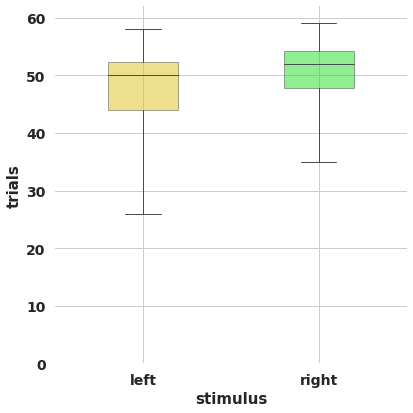

In [27]:
f, ax1 = plt.subplots(nrows =1, ncols=1, figsize=(6, 6))

ax3 = sns.boxplot(x="stimulus",y="trials",data=plotalerttrlnums_df, whis=np.inf, ax=ax1, width=0.4,
                  showbox=True,dodge=False,meanline=True,showmeans=False, showfliers=True,showcaps=True,
                  palette=pal,linewidth=1, boxprops=dict(alpha=.5), order=['left', 'right'])

ax1.set(xlabel='stimulus', ylabel='trials')
ax1.set(ylim=(0, 62))

ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "stimulusdecoding_alerttrialnums" + ".png", format='png', dpi=240, transparent=False)

In [28]:
alerttrialdetails_df

,subject,Right#,Left#
0,02,54,51
1,04,44,57
2,05,48,53
3,06,50,49
4,07,48,54
5,09,47,51
6,10,46,57
7,20,55,52
8,21,35,26
9,22,43,58


In [29]:
print('Available subjects:', len(subjects))
print('Used subjects:', len(scores_alert))

Available subjects: 32
Used subjects: 32


In [30]:
#compute the stats..
p_values_alert = _stats(np.array(scores_alert)[:, :, None] - chance)

number of subjects: 32
t-threshold is: 2.039513446396408
p-threshold is: 0.05
stat_fun(H1): min=-1.633513 max=6.644003
Running initial clustering
Found 2 clusters
Permuting 4095 times...
[                                                            ]   0.00%  |
Computing cluster p-values
Done.


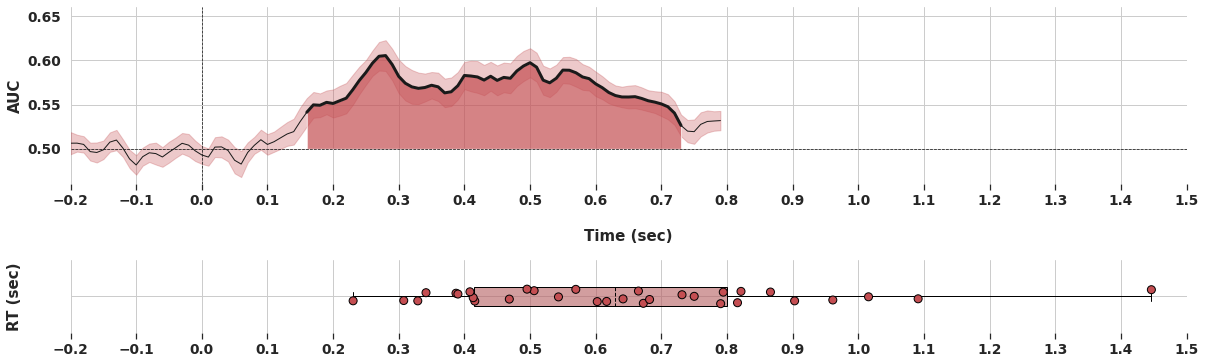

In [31]:
funcreturn, funcreturn2 = decodingplot(scores_alert,p_values_alert, times_alert, rts_alert, 
                                        alpha = 0.05, color = 'r',tmin= -0.2, tmax = 1.6)
funcreturn.axes.set_ylim(0.46, 0.66)
funcreturn.axes.set_ylabel('AUC')

funcreturn.axes.set_xlabel('\nTime (sec)')
funcreturn2.axes.set_ylabel('RT (sec)\n\n')
plt.savefig(fig_dir + "alert_corr_leftvsrightstim_decod.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

In [32]:
print('Decoding start(sig):'+ str(round(np.min(times_alert[p_values_alert < alpha]),2)), 'sec')
print('Decoding end(sig):'+ str(round(np.max(times_alert[p_values_alert < alpha]),2)), 'sec')
print('RT (mean):'+ str(round(np.mean(rts_alert),2)), 'sec')

Decoding start(sig):0.16 sec
Decoding end(sig):0.73 sec
RT (mean):0.65 sec


In [33]:
timeindex = (funcreturn.times>=0.16) & (funcreturn.times <=0.73)
tmpscoreindex = funcreturn.scores[timeindex].tolist()
print('mean:'+ str(np.mean(tmpscoreindex)))
print('sem:'+ str(stats.sem(tmpscoreindex)))

mean:0.5717699359244581
sem:0.0021933129872639037


In [34]:
print('Alert stim (leftvsright) decoding:')
timeindex = (funcreturn.times>=0.16) & (funcreturn.times <=0.73)
if any(timeindex):
    tmptimeindex = funcreturn.times[timeindex].tolist()
    tmpscoreindex = funcreturn.scores[timeindex].tolist()
    print ('max AUC of ' + str(round((max(tmpscoreindex)),3)) + ' at: ' + 
           str(round(tmptimeindex[tmpscoreindex.index(max(tmpscoreindex))],3)) + ' ms')

Alert stim (leftvsright) decoding:
max AUC of 0.605 at: 0.28 ms


In [35]:
print('Alert stim (leftvsright) decoding')
#timeindexes between 0.2 and 0.3 ms
timeindex = (funcreturn.times>=0.2) & (funcreturn.times <0.3)
if any(timeindex):
    tmptimeindex = funcreturn.times[timeindex].tolist()
    tmpscoreindex = funcreturn.scores[timeindex].tolist()
    print (' mean AUC of ' + str(round((np.mean(tmpscoreindex)),2)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')
    print (' sem AUC of ' + str(round((stats.sem(tmpscoreindex)),3)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')
#timeindexes between 0.3 and 0.4 ms
timeindex = (funcreturn.times>=0.3) & (funcreturn.times <0.4)
if any(timeindex):
    tmptimeindex = funcreturn.times[timeindex].tolist()
    tmpscoreindex = funcreturn.scores[timeindex].tolist()
    print (' mean AUC of ' + str(round((np.mean(tmpscoreindex)),2)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')
    print (' sem AUC of ' + str(round((stats.sem(tmpscoreindex)),3)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')

Alert stim (leftvsright) decoding
 mean AUC of 0.58 between: 0.2 ms and 0.29 ms
 sem AUC of 0.007 between: 0.2 ms and 0.29 ms
 mean AUC of 0.57 between: 0.3 ms and 0.4 ms
 sem AUC of 0.002 between: 0.3 ms and 0.4 ms


In [36]:
trials_cond1=[]
trials_cond2=[]
subj_cond = []

In [37]:
if rerun:
    for s, subject in enumerate(subjects):  # Loop across each subject
        print('processing subject: ',subject)
        tempcond1, tempcond2 =_run(subject,'Drowsy_Correct')
        trials_cond1.append(tempcond1)
        trials_cond2.append(tempcond2)
        subj_cond.append(subject)
    
scores_drowsy = list()  
rts_drowsy = list()
for s, subject in enumerate(subjects):  # Loop across each subject
    fpath = outputfolder + "s_"+ subject + "_" +  "Drowsy_Correct" + "_scores"
            
    if os.path.isfile(fpath):
        with open(fpath, 'rb') as f:
                score_drowsy, times_drowsy = pickle.load(f)
                scores_drowsy.append(score_drowsy)
    else:
                print("Skipping file")
            
    fpath = outputfolder + "s_"+ subject + "_" + "Drowsy_Correct" + "_rtval"
    
    if os.path.isfile(fpath):
        with open(fpath, 'rb') as f:
                rt_drowsy = pickle.load(f)
                rts_drowsy.append(rt_drowsy)
    else:
            print("Skipping file")

processing subject:  02
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_02_awake_drowsy_merged_800ms_posttrl_epochs.set...
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Drowsy_Correct classification(leftvsright)
Drowsy_Correct  (Right) trials # 140
Drowsy_Correct  (Left) trials # 115
Performing Drowsy_Correct classification(leftvsright)
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[....................................................

[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
mean RT:  1.1623917825485715
min RT:  0.279362814
processing subject:  27
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_27_awake_drowsy_merged_800ms_posttrl_epochs.set...
745 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Drowsy_Correct classification(leftvsright)
Drowsy_Correct  (Right) trials # 125
Drowsy_Correct  (Left) trials # 108
Performing Drowsy_Correct classification(leftvsright)
[..

[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
[............................................................] 100.00% Fitting SlidingEstimator |
mean RT:  0.5875995405780142
min RT:  0.199965657
processing subject:  44
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_44_awake_drowsy_merged_800ms_posttrl_epochs.set...
841 matching events found
No baseline correction applied
Not setting metadata
0 projection items activ

In [38]:
if rerun:
    trialdetails_list = list(zip(subj_cond, trials_cond1, trials_cond2))
    drowsytrialdetails_df = pd.DataFrame(trialdetails_list, columns=['subject', 'Right#', 'Left#'])
    drowsytrialdetails_df.to_csv(outputfolder + 'stimdecoding_drowsytrialdetails.csv', encoding='utf-8',
                                 index=False)
else:
    drowsytrialdetails_df = pd.read_csv(outputfolder + 'stimdecoding_drowsytrialdetails.csv')

In [39]:
plotdrowsytrlnums_df = drowsytrialdetails_df.melt(id_vars=["subject"], var_name="stimulus", value_name="trials")
plotdrowsytrlnums_df['subject'] = plotdrowsytrlnums_df['subject'].apply(str)
plotdrowsytrlnums_df['stimulus'] = plotdrowsytrlnums_df['stimulus'].map({'Right#': 'right', 'Left#': 'left'})
plotdrowsytrlnums_df

,subject,stimulus,trials
0,02,right,140.0
1,04,right,188.0
2,05,right,280.0
3,06,right,184.0
4,07,right,189.0
...,...,...,...
59,42,left,235.0
60,43,left,147.0
61,44,left,62.0
62,45,left,117.0


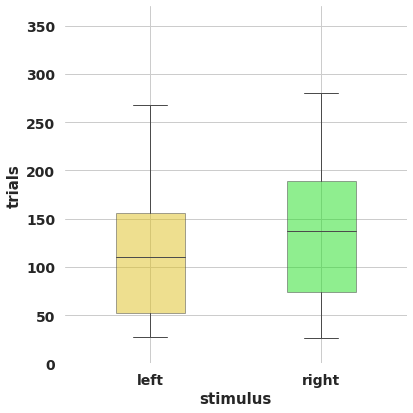

In [40]:
f, ax1 = plt.subplots(nrows =1, ncols=1, figsize=(6, 6))

ax3 = sns.boxplot(x="stimulus",y="trials",data=plotdrowsytrlnums_df, whis=np.inf, ax=ax1, width=0.4,
                  showbox=True,dodge=False,meanline=True,showmeans=False, showfliers=True,showcaps=True,
                  palette=pal,linewidth=1, boxprops=dict(alpha=.5), order=['left', 'right'])

ax1.set(xlabel='stimulus', ylabel='trials')
ax1.set(ylim=(0, 370))
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "stimulusdecoding_drowsytrialnums" + ".png", format='png', dpi=240, transparent=False)

In [41]:
drowsytrialdetails_df

,subject,Right#,Left#
0,02,140.0,115.0
1,04,188.0,259.0
2,05,280.0,234.0
3,06,184.0,192.0
4,07,189.0,194.0
5,09,49.0,89.0
6,10,149.0,131.0
7,20,138.0,117.0
8,21,189.0,159.0
9,22,169.0,268.0


In [42]:
print('Available subjects:', len(subjects))
print('Used subjects:', len(scores_drowsy))

Available subjects: 32
Used subjects: 30


In [43]:
#compute stats..
p_values_drowsy = _stats(np.array(scores_drowsy)[:, :, None] - chance)

number of subjects: 30
t-threshold is: 2.0452296421327034
p-threshold is: 0.05
stat_fun(H1): min=-1.508856 max=5.225681
Running initial clustering
Found 5 clusters
Permuting 4095 times...
[                                                            ]   0.00%  |
Computing cluster p-values
Done.


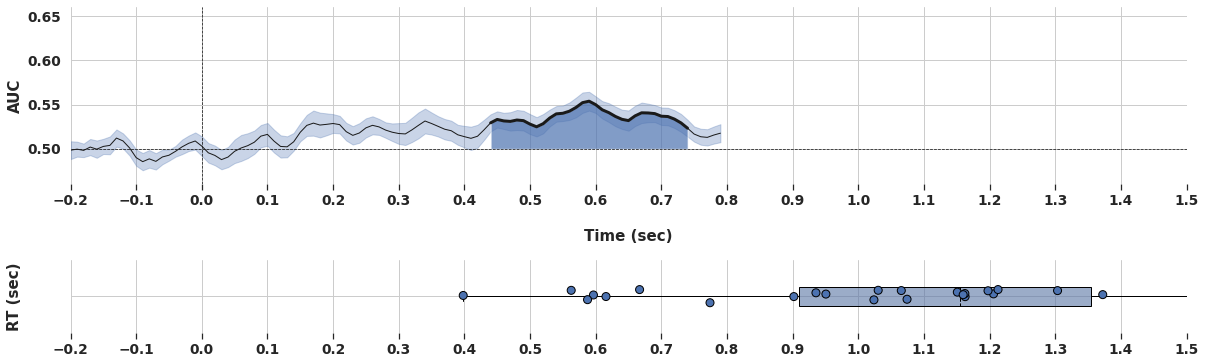

In [44]:
funcreturn, funcreturn2 = decodingplot(scores_drowsy,p_values_drowsy, times_drowsy, rts_drowsy, 
                                       alpha = 0.05, color = 'b',tmin= -0.2, tmax = 1.6)
funcreturn.axes.set_ylim(0.46, 0.66)
funcreturn.axes.set_ylabel('AUC')

funcreturn.axes.set_xlabel('\nTime (sec)')
funcreturn2.axes.set_ylabel('RT (sec)\n\n')
plt.savefig(fig_dir + "drowsy_corr_leftvsrightstim_decod.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

In [45]:
print('Decoding start(sig):'+ str(round(np.min(times_drowsy[p_values_drowsy < alpha]),2)), 'sec')
print('Decoding end(sig):'+ str(round(np.max(times_drowsy[p_values_drowsy < alpha]),2)), 'sec')
print('RT (mean):'+ str(round(np.mean(rts_drowsy),2)), 'sec')

Decoding start(sig):0.44 sec
Decoding end(sig):0.74 sec
RT (mean):1.18 sec


In [46]:
timeindex = (funcreturn.times>=0.42) & (funcreturn.times <=0.73)
tmpscoreindex = funcreturn.scores[timeindex].tolist()
print('mean:'+ str(np.mean(tmpscoreindex)))
print('sem:'+ str(stats.sem(tmpscoreindex)))

mean:0.5370234066795232
sem:0.0013232019941669896


In [47]:
print('Drowsy stim (leftvsright) decoding:')
timeindex = (funcreturn.times>=0.42) & (funcreturn.times <=0.73)
if any(timeindex):
    tmptimeindex = funcreturn.times[timeindex].tolist()
    tmpscoreindex = funcreturn.scores[timeindex].tolist()
    print ('max AUC of ' + str(round((max(tmpscoreindex)),3)) + ' at: ' + 
           str(round(tmptimeindex[tmpscoreindex.index(max(tmpscoreindex))],3)) + ' ms')

Drowsy stim (leftvsright) decoding:
max AUC of 0.554 at: 0.59 ms


In [48]:
print('Drowsy stim (leftvsright) decoding:')
#timeindexes between 0.420 and 0.5 ms
timeindex = (funcreturn.times>=0.42) & (funcreturn.times <0.5)
if any(timeindex):
    tmptimeindex = funcreturn.times[timeindex].tolist()
    tmpscoreindex = funcreturn.scores[timeindex].tolist()
    print ('mean AUC of ' + str(round((np.mean(tmpscoreindex)),2)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')
    print ('sem AUC of ' + str(round((stats.sem(tmpscoreindex)),3)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')
#timeindexes between 0.5 and 0.590 ms
timeindex = (funcreturn.times>0.5) & (funcreturn.times <=0.59)
if any(timeindex):
    tmptimeindex = funcreturn.times[timeindex].tolist()
    tmpscoreindex = funcreturn.scores[timeindex].tolist()
    print ('mean AUC of ' + str(round((np.mean(tmpscoreindex)),2)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')
    print ('sem AUC of ' + str(round((stats.sem(tmpscoreindex)),3)) + ' between: ' + 
           str(min(tmptimeindex)) + ' ms' + ' and ' + str(round(max(tmptimeindex),2)) + ' ms')

Drowsy stim (leftvsright) decoding:
mean AUC of 0.53 between: 0.44 ms and 0.5 ms
sem AUC of 0.001 between: 0.44 ms and 0.5 ms
mean AUC of 0.54 between: 0.51 ms and 0.58 ms
sem AUC of 0.003 between: 0.51 ms and 0.58 ms


## produce average evoked files based on the classifier patterns..

In [49]:
epochs_fnames = list()
awake_fnames = list()
for s, subject in enumerate(subjects):  # Loop across each subject
    fnamepath = outputfolder + "s_" + subject + "_" + "Alert_Correct" + "_evoked-ave.fif"
    if os.path.isfile(fnamepath):
        epochs_fnames.append(fnamepath)
        awake_fnames.append(subject)
    else:
        print("Skipping file")
    
evokeds_alert = [read_evokeds(f, verbose='error')[0] for f in epochs_fnames]
mean_evoked_alert = combine_evoked(evokeds_alert, weights="equal")
mean_evoked_alert.data = mean_evoked_alert.data/len(evokeds_alert)

In [50]:
len(evokeds_alert)

32

In [51]:
mean_evoked_alert

<Evoked  |  '1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment' (average, N=0.03125), [-0.2, 0.79] sec, 92 ch, ~313 kB>

In [52]:
n_tpts = len(times_alert)
n_epochs = len(evokeds_alert)
channels = mean_evoked_alert.ch_names
n_channels = len(channels)
events = np.array([np.arange(n_epochs), np.ones(n_epochs), np.ones(n_epochs)]).T.astype(int)
data = np.empty([n_epochs, n_channels, n_tpts])
for idx in range(n_epochs):
     data[idx,:,:] = evokeds_alert[idx].data
     events[idx][2] = int(awake_fnames[idx])

sfreq = 100  # Sampling frequency
times = mean_evoked_alert.times
info = mne.create_info(channels, sfreq=sfreq, ch_types = "eeg")

epochs = mne.EpochsArray(data, info, events)
epochs.shift_time(-0.2)
epochs.save(outputfolder + 'patterns/' 'awake_patterns_leftright_epo.fif',overwrite=True)

32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [53]:
import pylab as pl

In [54]:
topo_cmap = 'Spectral_r'

In [55]:
avgtime_per = 0.04 #averages 20ms before and 20ms after for the topoplot..

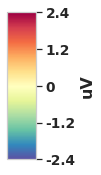

In [56]:
a = np.array([[-2.4,-1.2,0,1.2,2.4]])
pl.figure(figsize=[0.5, 3.4])

img = pl.imshow(a, cmap=topo_cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cbar = pl.colorbar(orientation="vertical",cax=cax)
cbar.set_ticks([-2.4,-1.2,0,1.2,2.4])
cbar.set_ticklabels([-2.4,-1.2,0,1.2,2.4])
cbar.set_label(label='uV',weight='heavy', size = 16)
plt.savefig(fig_dir + "topoplot_colorbar.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

In [57]:
topo_kwargs = dict(cmap = topo_cmap,time_unit='ms', show=False, show_names = False, 
                   average = avgtime_per,contours=9, sensors=False)

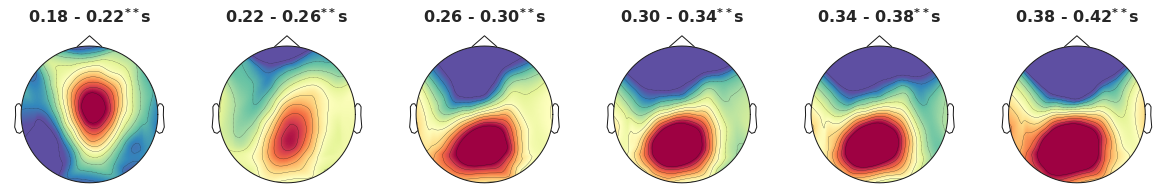

In [58]:
times = [0.2, 0.24, 0.28, 0.32,\
         0.36,0.40]
#stat annotation
time_format = ['0.18 - 0.22$^{**}$s', '0.22 - 0.26$^{**}$s', '0.26 - 0.30$^{**}$s', '0.30 - 0.34$^{**}$s',\
               '0.34 - 0.38$^{**}$s', '0.38 - 0.42$^{**}$s']

cmin =-2.4
cmax = 2.4

fig, ax = plt.subplots(nrows=1, ncols=len(times), figsize=[20., 3.4])


for idx in range(len(times)):
        mean_evoked_alert.plot_topomap(axes = ax[idx],times=times[idx], time_format = time_format[idx],
                                   vmin = cmin, vmax = cmax,colorbar=False,**topo_kwargs)

        
for idx in range(len(times)):
    for item in ([ax[idx].title, ax[idx].xaxis.label, ax[idx].yaxis.label] +
                 ax[idx].get_xticklabels() + ax[idx].get_yticklabels()):
                 item.set_fontsize(16)
                 item.set_fontweight('heavy')
plt.savefig(fig_dir + "alert_corr_leftvsrightstim_pattn_1.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

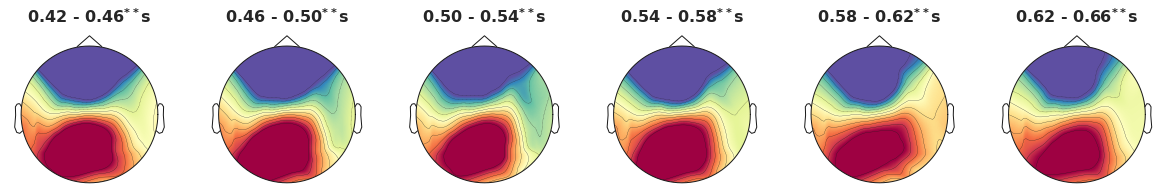

In [59]:
times = [0.44, 0.48, 0.52, 0.56, 0.60,\
         0.64]
avgtime_per = 0.04 #averages 20ms before and 20ms after for the topoplot..
#stat annotation
time_format = ['0.42 - 0.46$^{**}$s','0.46 - 0.50$^{**}$s', '0.50 - 0.54$^{**}$s', '0.54 - 0.58$^{**}$s',\
               '0.58 - 0.62$^{**}$s','0.62 - 0.66$^{**}$s']

cmin =-2.4
cmax = 2.4

fig, ax = plt.subplots(nrows=1, ncols=len(times), figsize=[20., 3.4])


for idx in range(len(times)):
        mean_evoked_alert.plot_topomap(axes = ax[idx],times=times[idx], time_format = time_format[idx],
                                   vmin = cmin, vmax = cmax,colorbar=False,**topo_kwargs)

        
for idx in range(len(times)):
    for item in ([ax[idx].title, ax[idx].xaxis.label, ax[idx].yaxis.label] +
                 ax[idx].get_xticklabels() + ax[idx].get_yticklabels()):
                 item.set_fontsize(16)
                 item.set_fontweight('heavy')
plt.savefig(fig_dir + "alert_corr_leftvsrightstim_pattn_2.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

In [60]:
mean_evoked_alert.save(outputfolder + 'patterns/' + 'awake_patterns_leftright_ave.fif')

<ipython-input-60-6d0cdaffc8f0>:1: RuntimeWarning: converting "nave" to integer before saving evoked; this can have a minor effect on the scale of source estimates that are computed using "nave".
  mean_evoked_alert.save(outputfolder + 'patterns/' + 'awake_patterns_leftright_ave.fif')


In [61]:
epochs_fnames = list()
drowsy_fnames = list()
for s, subject in enumerate(subjects):  # Loop across each subject
    fnamepath = outputfolder + "s_" + subject + "_" + "Drowsy_Correct" + "_evoked-ave.fif"
    if os.path.isfile(fnamepath):
        epochs_fnames.append(fnamepath)
        drowsy_fnames.append(subject)
    else:
        print("Skipping file")
    
evokeds_drowsy = [read_evokeds(f, verbose='error')[0] for f in epochs_fnames]
mean_evoked_drowsy = combine_evoked(evokeds_drowsy, weights="equal")
mean_evoked_drowsy.data = mean_evoked_drowsy.data/len(evokeds_drowsy)

Skipping file
Skipping file


In [62]:
mean_evoked_drowsy

<Evoked  |  '1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment + 1.000 * No comment' (average, N=0.03333333333333333), [-0.2, 0.79] sec, 92 ch, ~313 kB>

In [63]:
n_tpts = len(times_alert)
n_epochs = len(evokeds_drowsy)
channels = mean_evoked_drowsy.ch_names
n_channels = len(channels)
events = np.array([np.arange(n_epochs), np.ones(n_epochs), np.ones(n_epochs)]).T.astype(int)
data = np.empty([n_epochs, n_channels, n_tpts])
for idx in range(n_epochs):
     data[idx,:,:] = evokeds_drowsy[idx].data
     events[idx][2] = int(drowsy_fnames[idx])

sfreq = 100  # Sampling frequency
times = mean_evoked_drowsy.times
info = mne.create_info(channels, sfreq=sfreq, ch_types = "eeg")

epochs = mne.EpochsArray(data, info, events)
epochs.shift_time(-0.2)
epochs.save(outputfolder + 'patterns/' + 'drowsy_patterns_leftright_epo.fif',overwrite=True)

30 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


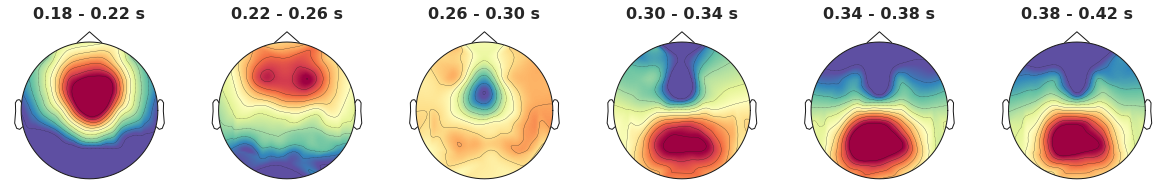

In [64]:
times = [0.2, 0.24, 0.28, 0.32,\
         0.36,0.40]
#stat annotation
time_format = ['0.18 - 0.22 s', '0.22 - 0.26 s', '0.26 - 0.30 s', '0.30 - 0.34 s',\
               '0.34 - 0.38 s', '0.38 - 0.42 s']


cmin =-2.4
cmax = 2.4

fig, ax = plt.subplots(nrows=1, ncols=len(times), figsize=[20., 3.4])


for idx in range(len(times)):
        mean_evoked_drowsy.plot_topomap(axes = ax[idx],times=times[idx], time_format = time_format[idx],
                                   vmin = cmin, vmax = cmax,colorbar=False,**topo_kwargs)
        
for idx in range(len(times)):
    for item in ([ax[idx].title, ax[idx].xaxis.label, ax[idx].yaxis.label] +
                 ax[idx].get_xticklabels() + ax[idx].get_yticklabels()):
                 item.set_fontsize(16)
                 item.set_fontweight('heavy')
plt.savefig(fig_dir + "drowsy_corr_leftvsrightstim_pattn_1.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

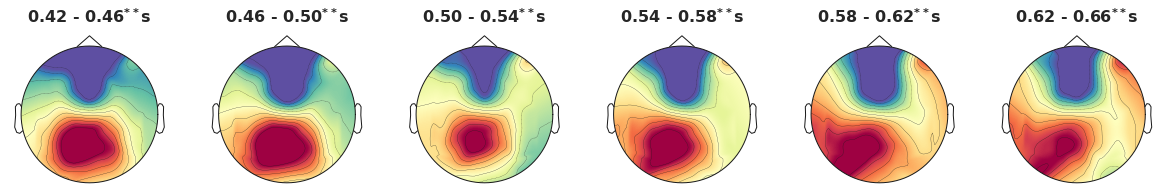

In [65]:
times = [0.44, 0.48, 0.52, 0.56, 0.60,\
         0.64]
#stat annotation
time_format = ['0.42 - 0.46$^{**}$s','0.46 - 0.50$^{**}$s', '0.50 - 0.54$^{**}$s', '0.54 - 0.58$^{**}$s',\
               '0.58 - 0.62$^{**}$s','0.62 - 0.66$^{**}$s']


cmin =-2.4
cmax = 2.4

fig, ax = plt.subplots(nrows=1, ncols=len(times), figsize=[20., 3.4])


for idx in range(len(times)):
        mean_evoked_drowsy.plot_topomap(axes = ax[idx],times=times[idx], time_format = time_format[idx],
                                   vmin = cmin, vmax = cmax,colorbar=False,**topo_kwargs)
        
for idx in range(len(times)):
    for item in ([ax[idx].title, ax[idx].xaxis.label, ax[idx].yaxis.label] +
                 ax[idx].get_xticklabels() + ax[idx].get_yticklabels()):
                 item.set_fontsize(16)
                 item.set_fontweight('heavy')
plt.savefig(fig_dir + "drowsy_corr_leftvsrightstim_pattn_2.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

In [66]:
mean_evoked_drowsy.save(outputfolder + 'patterns/' + 'drowsy_patterns_leftright_ave.fif')

<ipython-input-66-8e7a5c70f804>:1: RuntimeWarning: converting "nave" to integer before saving evoked; this can have a minor effect on the scale of source estimates that are computed using "nave".
  mean_evoked_drowsy.save(outputfolder + 'patterns/' + 'drowsy_patterns_leftright_ave.fif')


## produce difference between classifier patterns across conditions..

## Alert_Correct vs Drowsy_Correct

In [67]:
epochs_fnames1 = list()
epochs_fnames2 = list()
for s, subject in enumerate(subjects):  # Loop across each subject
    fnamepath1 = outputfolder + "s_" + subject + "_" + "Alert_Correct" + "_evoked-ave.fif"
    fnamepath2 = outputfolder + "s_" + subject + "_" + "Drowsy_Correct" + "_evoked-ave.fif"
    if os.path.isfile(fnamepath1) and os.path.isfile(fnamepath2):
        epochs_fnames1.append(fnamepath1)
        epochs_fnames2.append(fnamepath2)
    else:
        print("Skipping file")
    
evokeds_alert = [read_evokeds(f, verbose='error')[0] for f in epochs_fnames1]
evokeds_drowsy = [read_evokeds(f, verbose='error')[0] for f in epochs_fnames2]

Skipping file
Skipping file


In [68]:
n_tpts = len(evokeds_alert[0].times)
n_epochs = len(evokeds_alert)
channels = evokeds_alert[0].ch_names
n_channels = len(channels)
events = np.array([np.arange(n_epochs), np.ones(n_epochs), np.ones(n_epochs)]).T.astype(int)
cond1_data = np.empty([n_epochs, n_channels, n_tpts])
cond2_data = np.empty([n_epochs, n_channels, n_tpts])
for idx in range(n_epochs):
     cond1_data[idx,:,:] = evokeds_alert[idx].data
     cond2_data[idx,:,:] = evokeds_drowsy[idx].data

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 92
<class 'scipy.sparse.csr.csr_matrix'>


Text(0.5, 1.0, 'Between-sensor adjacency')

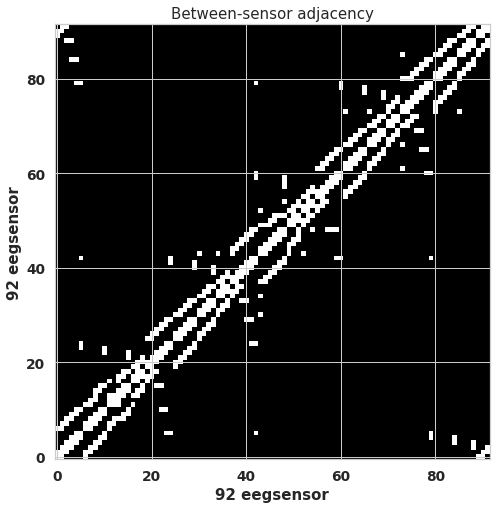

In [69]:
from mne.channels import find_ch_connectivity
eeg_connectivity, ch_names = find_ch_connectivity(evokeds_alert[0].info, ch_type='eeg')
print(type(eeg_connectivity))  # it's a sparse matrix!

plt.imshow(eeg_connectivity.toarray(), cmap='gray', origin='lower',
           interpolation='nearest')
plt.xlabel('{} eegsensor'.format(len(ch_names)))
plt.ylabel('{} eegsensor'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [70]:
print('Condition#1 data: ',cond1_data.shape)
print('Condition#2 data: ',cond2_data.shape)

Condition#1 data:  (30, 92, 100)
Condition#2 data:  (30, 92, 100)


In [71]:
cond1_data = np.transpose(cond1_data, (0, 2, 1))# transpose for clustering
cond2_data = np.transpose(cond2_data, (0, 2, 1))# transpose for clustering
print('Condition#1 data: ',cond1_data.shape)
print('Condition#2 data: ',cond2_data.shape)

Condition#1 data:  (30, 100, 92)
Condition#2 data:  (30, 100, 92)


In [72]:
X_data = cond1_data-cond2_data
X_data.shape

(30, 100, 92)

In [73]:
# two tailed t-value verified with.. https://goodcalculators.com/student-t-value-calculator/ 
# (df = 29, alpha = 0.05) -> t = 2.04

In [74]:
n_subj = len(cond1_data)
p_threshold = 0.05
t_threshold = -stats.distributions.t.ppf(p_threshold/2., n_subj - 1) 
T_obs, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(X_data,
                                                                   tail = 0, n_permutations=2**12,
                                                                   seed = 1234,
                                                                   n_jobs=1, connectivity=eeg_connectivity,
                                                                   threshold=t_threshold)

good_cluster_inds = np.where(p_values < p_threshold)[0]

stat_fun(H1): min=-6.328886 max=4.809342
Running initial clustering
Found 28 clusters
Permuting 4095 times...
[............................................................] 100.00%  |
Computing cluster p-values
Done.


In [75]:
good_cluster_inds

array([ 7,  9, 17, 20])

In [76]:
for ii, cluster_ind in enumerate(good_cluster_inds):
        v_inds = clusters[cluster_ind][1]
        t_inds = clusters[cluster_ind][0]
        print('Cluster#',str(ii+1), 'from: ', round(np.min(np.unique(evokeds_alert[0].times[t_inds])),2), 
              ' to: ', round(np.max(np.unique(evokeds_alert[0].times[t_inds])),2))

Cluster# 1 from:  0.15  to:  0.33
Cluster# 2 from:  0.43  to:  0.65
Cluster# 3 from:  0.17  to:  0.36
Cluster# 4 from:  0.38  to:  0.65


In [77]:
len(clusters)

28

In [78]:
# get sensor positions via layout
pos = mne.find_layout(evokeds_alert[0].info).pos

In [79]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_topomap
from mne.viz import plot_compare_evokeds

In [80]:
evokeds_plot = {"Alert":evokeds_alert,"Drowsy":evokeds_drowsy}

In [81]:
colors = {"Alert": "r", "Drowsy": 'b'}
linestyles = ['-','-']

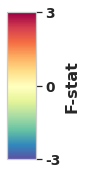

In [82]:
a = np.array([[-3,0,3]])
pl.figure(figsize=[0.5, 3.4])

img = pl.imshow(a, cmap=topo_cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cbar = pl.colorbar(orientation="vertical",cax=cax)
cbar.set_ticks([-3,0,3])
cbar.set_ticklabels([-3,0,3])
cbar.set_label(label='F-stat',weight='heavy', size = 16)
plt.savefig(fig_dir + "AlertvsDrowsy_pattn_clust_colorbar.png", dpi=240, bbox_inches = 'tight',
            transparent=False, pad_inches = 0.1)

In [83]:
mask_params = dict(marker='o', markerfacecolor='grey', markeredgecolor='k', linewidth=0, markersize=7)

In [84]:
eleclocs = evokeds_alert[0].ch_names

early cluster (0.15 - 0.33 s)
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
late cluster (0.43 - 0.65 s)
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
early cluster (0.17 - 0.36 s)
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
late cluster (0.38 - 0.65 s)
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


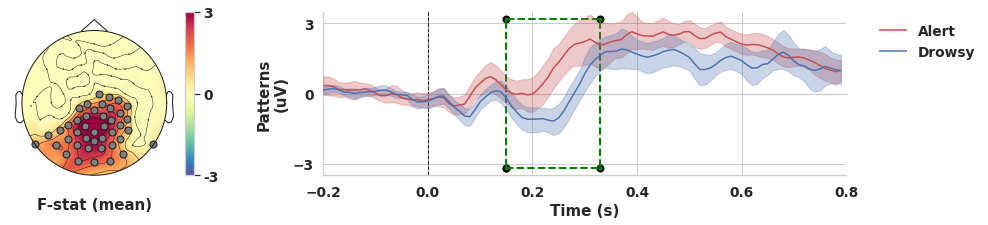

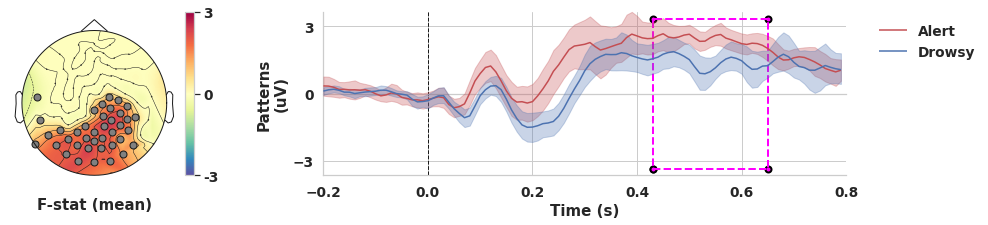

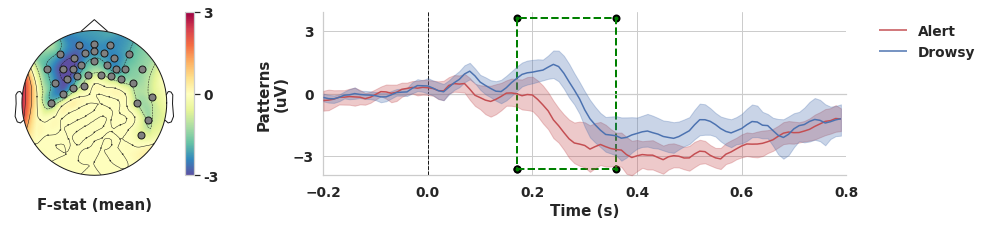

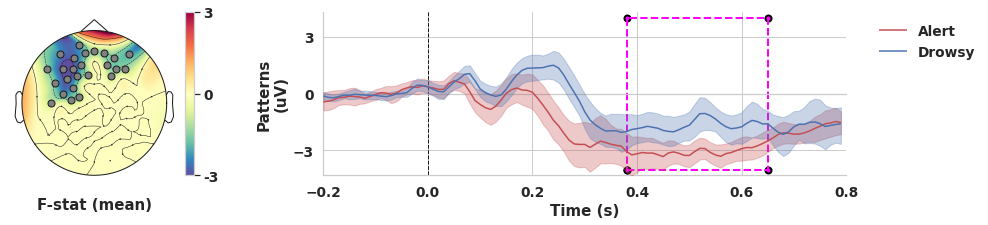

In [85]:
# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    if i_clu == 0:
        spat_locsAlert = list(eleclocs[idx] for idx in ch_inds)
    else:
        spat_locsDrowsy = list(eleclocs[idx] for idx in ch_inds)
    time_inds = np.unique(time_inds)
    
    # get topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)
    
    # get signals at the sensors contributing to the cluster
    sig_times = times_alert[time_inds]
    
    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True
    
    minval = -3
    maxval = 3
    
    f_map = np.squeeze(mask)*f_map


    # initialize figure
    if i_clu == 0:
        fig, ax_topo = plt.subplots(1, 1, figsize=(14, 4.5))
    else:
        fig, ax_topo = plt.subplots(1, 1, figsize=(14, 4))
    

    # plot average test statistic and mark significant sensors
    image, _ = plot_topomap(f_map, pos, mask=mask, axes=ax_topo, cmap=topo_cmap,mask_params = mask_params,
                            vmin=minval, vmax=maxval, show=False)
    
    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(image, cax=ax_colorbar)
    cbar.mappable.set_clim(-3, 3)
    cbar.set_ticks([-3, 0, 3])
    cbar.set_ticklabels([-3, 0, 3])
    ax_topo.set_xlabel('\nF-stat (mean)')
    
    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.8)

    
    if sig_times[0] < 0.2:
        title = 'early cluster ({:0.2f} - {:0.2f} s)'.format(*sig_times[[0, -1]])
    else:
        title = 'late cluster ({:0.2f} - {:0.2f} s)'.format(*sig_times[[0, -1]])

    print(title)
    
    if len(ch_inds) > 1:
        title += ""
    evok_plt = plot_compare_evokeds(evokeds_plot, picks=ch_inds, title = None, axes=ax_signals,legend = True,
                         show=False, colors=colors, linestyles=linestyles, combine = 'mean',
                         split_legend=True, truncate_yaxis=False, truncate_xaxis=False, ci = .95)
    
    ax_signals.set_title('')
    if i_clu == 0:
        title = title
        
    ax_signals.legend(bbox_to_anchor=(1.04,1), loc="upper left",facecolor='white', framealpha=0)
    ax_signals.set_yticks([-3,0,3])
    ax_signals.set_xticks([-0.2,0,0.2,0.4,0.6,0.8])
    ax_signals.set_ylabel('Patterns\n(uV)')
    
    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()

    if i_clu == 0 or i_clu == 2:
        highlightcol = 'green'
    else:
        highlightcol = 'magenta'
        
    ax_signals.plot([sig_times[0], sig_times[-1], sig_times[-1],sig_times[0], sig_times[0]], 
                    [ymin+0.3,         ymin+0.3,          ymax-0.3,         ymax-0.3,       ymin+0.3], 
                    '--', color = highlightcol, linewidth = 2)
    ax_signals.scatter([sig_times[0], sig_times[-1], sig_times[-1],sig_times[0], sig_times[0]], 
                       [ymin+0.3,         ymin+0.3,          ymax-0.3,         ymax-0.3,       ymin+0.3],
                       marker = 'o', edgecolor='black', linewidth=2, color = highlightcol)

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    #plt.show()
    
    plt.savefig(fig_dir + "AlertvsDrowsy_pattn_clust_" + str(i_clu+1) + ".png", dpi=240, 
                bbox_inches = 'tight', transparent=False, pad_inches = 0.1)

In [86]:
# simply plot erp values in the significant electrodes idenfified by the above patterns..

In [87]:
erp_alert = list() 
erp_drowsy = list()
for s, subject in enumerate(subjects):  # Loop across each subject
    print(subject)
    epoched_erp1 = _erpplot(subject,'Alert_Correct')
    epoched_erp2 = _erpplot(subject,'Drowsy_Correct')
    
    if (epoched_erp1 is not None) and (epoched_erp2 is not None):
        erp_alert.append(epoched_erp1)
        erp_drowsy.append(epoched_erp2)

02
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_02_awake_drowsy_merged_800ms_posttrl_epochs.set...
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Alert_Correct classification(leftvsright)
54
51
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_02_awake_drowsy_merged_800ms_posttrl_epochs.set...
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Drowsy_Correct classification(leftvsright)
140
115
04
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_

Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_23_awake_drowsy_merged_800ms_posttrl_epochs.set...
747 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Alert_Correct classification(leftvsright)
53
49
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_23_awake_drowsy_merged_800ms_posttrl_epochs.set...
747 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Drowsy_Correct classification(leftvsright)
223
222
24
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_pro

Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_34_awake_drowsy_merged_800ms_posttrl_epochs.set...
833 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Alert_Correct classification(leftvsright)
52
52
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_34_awake_drowsy_merged_800ms_posttrl_epochs.set...
833 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Drowsy_Correct classification(leftvsright)
6
4
Cant get data out..
35
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/p

Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_45_awake_drowsy_merged_800ms_posttrl_epochs.set...
820 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Alert_Correct classification(leftvsright)
53
26
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_processed/s_45_awake_drowsy_merged_800ms_posttrl_epochs.set...
820 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Performing Drowsy_Correct classification(leftvsright)
191
117
46
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/12_pro

In [88]:
evokeds_plot = {"Alert":erp_alert,"Drowsy":erp_drowsy}

In [89]:
mask_params = dict(marker='o', markerfacecolor='grey', markeredgecolor='black', linewidth=0, markersize=7)

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


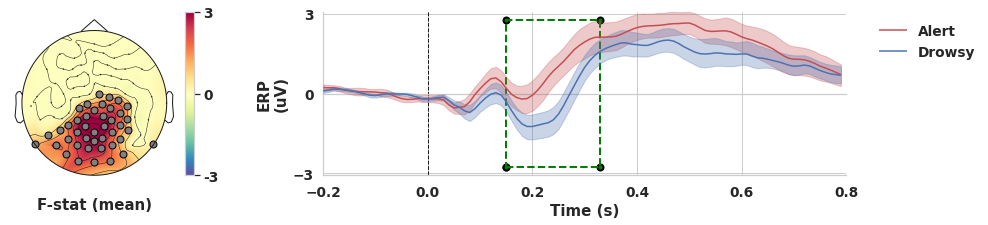

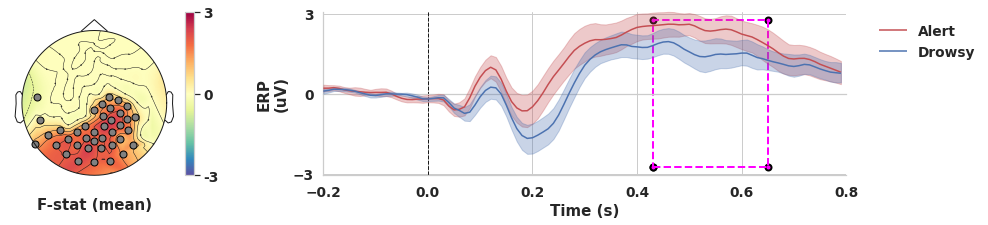

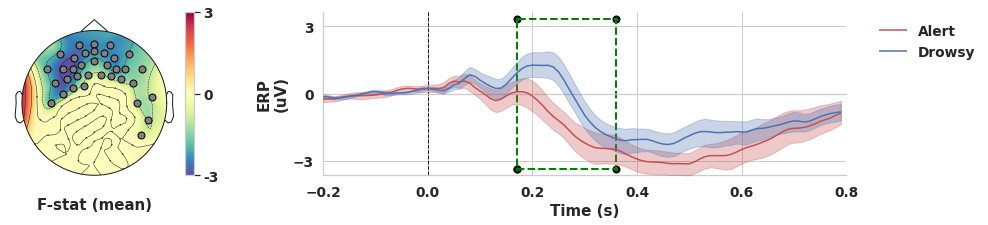

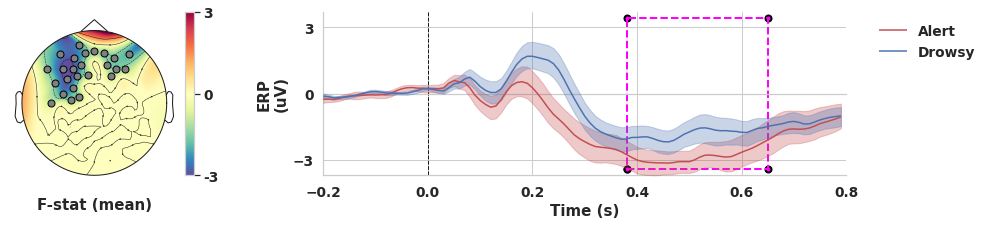

In [90]:
# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    
    # get topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)
    
    # get signals at the sensors contributing to the cluster
    sig_times = times_alert[time_inds]
    
    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True
    
    minval = -3
    maxval = 3
    
    f_map = np.squeeze(mask)*f_map


    # initialize figure
    if i_clu == 0:
        fig, ax_topo = plt.subplots(1, 1, figsize=(14, 4.5))
    else:
        fig, ax_topo = plt.subplots(1, 1, figsize=(14, 4))
    

    # plot average test statistic and mark significant sensors
    image, _ = plot_topomap(f_map, pos, mask=mask, axes=ax_topo, cmap=topo_cmap,mask_params = mask_params,
                            vmin=minval, vmax=maxval, show=False)
    
    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(image, cax=ax_colorbar)
    cbar.set_ticks([-3, 0, 3])
    cbar.set_ticklabels([-3, 0, 3])
    ax_topo.set_xlabel('\nF-stat (mean)')
    
    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.8)
    
    if sig_times[0] < 0.2:
        title = 'early cluster ({:0.2f} - {:0.2f} s)'.format(*sig_times[[0, -1]])
    else:
        title = 'late cluster ({:0.2f} - {:0.2f} s)'.format(*sig_times[[0, -1]])
    
    if len(ch_inds) > 1:
        title += "s"
    evok_plt = plot_compare_evokeds(evokeds_plot, picks=ch_inds, title = None, axes=ax_signals,legend = True,
                         show=False, colors=colors, linestyles=linestyles, combine = 'mean',
                         split_legend=True, truncate_yaxis=False,truncate_xaxis=False, ci = .95)
    
    ax_signals.set_title('')
    if i_clu == 0:
        title = ''

        
    ax_signals.legend(bbox_to_anchor=(1.04,1), loc="upper left",facecolor='white', framealpha=0)
    ax_signals.set_yticks([-3,0,3])
    ax_signals.set_xticks([-0.2,0,0.2,0.4,0.6,0.8])
    ax_signals.set_ylabel('ERP\n(uV)')
    
    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
        
    if i_clu == 0 or i_clu == 2:
        highlightcol = 'green'
    else:
        highlightcol = 'magenta'

    ax_signals.plot([sig_times[0], sig_times[-1], sig_times[-1],sig_times[0], sig_times[0]], 
                    [ymin+0.3,         ymin+0.3,          ymax-0.3,         ymax-0.3,       ymin+0.3], 
                    '--', color = highlightcol, linewidth = 2)
    ax_signals.scatter([sig_times[0], sig_times[-1], sig_times[-1],sig_times[0], sig_times[0]], 
                       [ymin+0.3,         ymin+0.3,          ymax-0.3,         ymax-0.3,       ymin+0.3],
                       marker = 'o', edgecolor='black', linewidth=2, color = highlightcol)

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    #plt.show()
    
    plt.savefig(fig_dir + "AlertvsDrowsy_pattn_clust_" + str(i_clu+1) + "_erpplot.png", dpi=240, 
                bbox_inches = 'tight', transparent=False, pad_inches = 0.1)